# SelectFeatures
This notebook shows the development of how we shrink the size of features from `ChemFeatures` to study with. We used the following method to analyze the weight of each feature:

* RIDGE (Ridge Regression)
* LASSO (Least Absolute Shrinkage and Selection Operator)
* Random Forest
* RFE (Recursive Feature Elimination)

We use explained variance to compare and evaluate these methods for final decision making.<br>

#### Use ``ChemFeatures`` to generate a dataframe of features.

In [7]:
import pandas as pd
# Module for extracting ChemInfo
from SeekFeatures import ChemFeatures
import mordred
import numpy as np

# plotting package
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Use 100K data for demonstration
data = pd.read_csv('../Database/HCEPD_100K.csv') 
# Use first 50 data to illustrate the analysis
data50 = data.head(50)
data50.head()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
0,655365,C1C=CC=C1c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,C18H9N3OSSe,394.3151,5.161953,0.867601,91.567575,-5.467601,2.022944,-3.444656,C1=CC=C(C1)c1cc2[se]c3c4occc4c4nsnc4c3c2cn1
1,1245190,C1C=CC=C1c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH2]...,C22H15NSeSi,400.4135,5.261398,0.504824,160.401549,-5.104824,1.630750,-3.474074,C1=CC=C(C1)c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH...
2,21847,C1C=c2ccc3c4c[nH]cc4c4c5[SiH2]C(=Cc5oc4c3c2=C1...,C24H17NOSi,363.4903,0.000000,0.000000,197.474780,-4.539526,1.462158,-3.077368,C1=CC=C(C1)C1=Cc2oc3c(c2[SiH2]1)c1c[nH]cc1c1cc...
3,65553,[SiH2]1C=CC2=C1C=C([SiH2]2)C1=Cc2[se]ccc2[SiH2]1,C12H12SeSi3,319.4448,6.138294,0.630274,149.887545,-5.230274,1.682250,-3.548025,C1=CC2=C([SiH2]1)C=C([SiH2]2)C1=Cc2[se]ccc2[Si...
4,720918,C1C=c2c3ccsc3c3[se]c4cc(oc4c3c2=C1)C1=CC=CC1,C20H12OSSe,379.3398,1.991366,0.242119,126.581347,-4.842119,1.809439,-3.032680,C1=CC=C(C1)c1cc2[se]c3c4sccc4c4=CCC=c4c3c2o1


Generate a dataframe of chemical features.

In [3]:
features_df = ChemFeatures(data50['SMILES_str'])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  4.67it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.10it/s]


In [4]:
features_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,20.142136,16.169815,0,0,33.204238,2.616114,5.057172,33.204238,1.383510,4.188377,...,10.460213,77.559765,394.963154,11.968580,1216,42,146.0,185.0,4.611111,5.000000
1,20.849242,16.133746,0,0,34.755190,2.600656,5.047921,34.755190,1.390208,4.221130,...,10.493799,77.890806,401.013897,10.025347,1337,45,150.0,189.0,4.861111,5.250000
2,22.889683,17.893320,0,0,37.437727,2.645420,5.160050,37.437727,1.386582,4.315006,...,10.639862,82.032579,363.107941,8.252453,1635,49,168.0,215.0,5.083333,5.555556
3,13.313708,11.688393,0,0,21.283525,2.481194,4.637583,21.283525,1.330220,3.777767,...,9.782393,66.966647,319.941201,11.426471,430,20,94.0,115.0,3.166667,3.333333
4,19.435029,15.989365,0,0,31.670490,2.627835,5.062549,31.670490,1.376978,4.154569,...,10.429310,77.119188,379.977407,10.856497,1074,39,142.0,181.0,4.361111,4.750000


> Not all molecules have the same features as others, so there will be some non-value entries hidden in the dataframe.

In [5]:
# find the non-value entries.

missing =[]
for i in range(features_df.shape[1]):
    if type(features_df.loc[1][i]) == mordred.error.Missing:
        missing.append(features_df.loc[1][i])

# show examples of the non-value entries.        
missing[0:5]

> **for these non-value entries, we assign them to 0, simply indicating that the molecule does not possess that specific feature.**

In [8]:
# first locate the columns that contain missing values
type_series = features_df.dtypes
wrong_column = []
for col in range(len(type_series)):
    if type_series[col] != np.float64 and type_series[col] != np.int64:
        wrong_column.append(col)

# use for loop within the columns found above and 
# replace the missing values to 0
for column in wrong_column:
    i = 0
    for item in features_df.iloc[:,column]:
        if type(item) != np.float64 and type(item) != np.int64:
            features_df.iloc[i,column] = 0
        i += 1


In [12]:
# check if missing values have been replaced by 0
print(np.unique(features_df.dtypes))
missing_check =[]
for i in range(features_df.shape[1]):
    if type(features_df.loc[1][i]) == mordred.error.Missing:
        missing_check.append(features_df.loc[1][i])
missing_check


[dtype('int64') dtype('float64') dtype('O')]


[]

* **Standarlize feature values for regression**

In [13]:
from sklearn.preprocessing import StandardScaler
features =[feature for feature in features_df.columns]

# Separating out the features
x = features_df.loc[:, features].values

# Our target is pce
y = data50['pce'].values
sc = StandardScaler()
X = sc.fit_transform(x)


c:\users\alex0\anaconda3\envs\pvc-env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\alex0\anaconda3\envs\pvc-env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [171]:
features = [ftr for ftr in features_df.head()]
ranks = {}
def rank_to_dict(ranks, names, order=1):
    sc = StandardScaler()
    ranks = sc.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

### Linear regression model
Here, we chose two most commonly used linear regression models to shrink the coefficients: Ridge and LASSO. Both of them describes the weights of each feature contributing to the response in a linear model, and introduce a penalty term (&lambda;) to include the error from the magnitude of feature coefficient. The difference between them is the way they calculate the penalty. While RIDGE tries to shrink all coefficients closer to zero due to its square term, LASSO takes the absolutie value of coef to eliminate some 0 term and leave the significant term.<br>

We applied both methods to our dataset and tried to compare them by plotting error vs r2. They are included in ``ShrinkCoef``. Users can also decide which one to use for their data by calling these functions. 

In [32]:
# import package
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


# applied k-fold cross-validation to the process of sampling.
kf = KFold(n_splits = 10, shuffle = True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


In [33]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

45 5 45 5


* **Ridge regression (RR)**

In [48]:
from sklearn.linear_model import Ridge
# RR vs lambda 
coefs_RR = []
train_error_RR = []
test_error_RR = []

# Tunning parameter(lambda)
lambdas_RR = np.logspace(-4,8,200)
modelRR = Ridge()

# loop over lambda values to determine the best by mse
for l in lambdas_RR:
    modelRR.set_params(alpha = l)
    modelRR.fit(X_train, y_train)
    coefs_RR.append(modelRR.coef_)
    train_error_RR.append(mean_squared_error(y_train, modelRR.predict(X_train)))
    test_error_RR.append(mean_squared_error(y_test, modelRR.predict(X_test)))

Text(0.5, 1.0, 'MSE vs $\\lambda$')

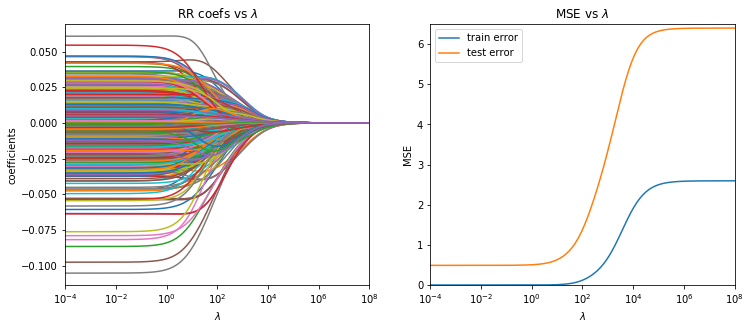

In [49]:
fig = plt.figure(figsize=(12, 4.8))

ax1 = plt.subplot(1, 2, 1)
plt.plot(lambdas_RR, coefs_RR)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('coefficients')
plt.title('RR coefs vs $\lambda$')
plt.xlim(1e-4, 1e8)

ax2 = plt.subplot(1, 2, 2)
plt.plot(lambdas_RR, train_error_RR, label = 'train error')
plt.plot(lambdas_RR, test_error_RR, label = 'test error')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.xlim(1e-4, 1e8)
plt.ylim(0, 6.5)
plt.legend(loc = 'upper left')
plt.title('MSE vs $\lambda$')

In [184]:
# choose lambda = 1e-2 and find coef.

180418.64093920754

* **LASSO regression**

In [52]:
from sklearn.linear_model import Lasso
# RR vs lambda 
coefs_Lasso = []
train_error_Lasso = []
test_error_Lasso = []

# Tunning parameter(lambda)
lambdas_Lasso = np.logspace(-4,8,200)
modelLasso = Lasso(max_iter = 1e4)

# loop over lambda values to determine the best by mse
for l in lambdas_Lasso:
    modelLasso.set_params(alpha = l)
    modelLasso.fit(X_train, y_train)
    coefs_Lasso.append(modelLasso.coef_)
    train_error_Lasso.append(mean_squared_error(y_train, modelLasso.predict(X_train)))
    test_error_Lasso.append(mean_squared_error(y_test, modelLasso.predict(X_test)))

Text(0.5, 1.0, 'MSE vs $\\lambda$')

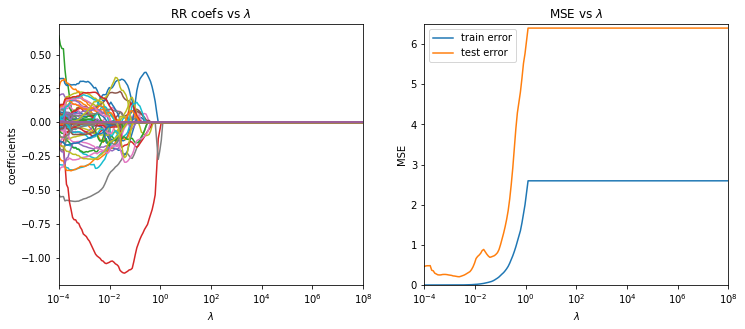

In [53]:
fig = plt.figure(figsize=(12, 4.8))

ax1 = plt.subplot(1, 2, 1)
plt.plot(lambdas_Lasso, coefs_Lasso)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('coefficients')
plt.title('RR coefs vs $\lambda$')
plt.xlim(1e-4, 1e8)

ax2 = plt.subplot(1, 2, 2)
plt.plot(lambdas_Lasso, train_error_Lasso, label = 'train error')
plt.plot(lambdas_Lasso, test_error_Lasso, label = 'test error')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.xlim(1e-4, 1e8)
plt.ylim(0, 6.5)
plt.legend(loc = 'upper left')
plt.title('MSE vs $\lambda$')

### Tree Based Methods
In addition to linear and non-linear regression, tree based model provides a more flexible method to describe the bonding between features and our target. 

* **Random Forest**

In [55]:
from sklearn.ensemble import RandomForestRegressor 

modelRF = RandomForestRegressor()
modelRF.fit(X_train, y_train)

c:\users\alex0\anaconda3\envs\pvc-env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [59]:
RFrank = modelRF.feature_importances_

In [60]:
RFdf = pd.DataFrame({'Feature':features_df.columns.values, 'Rank':RFrank}).sort_values('Rank',ascending=False)


### Recursive Feature Elimination (RFE)

Lastly, we also take advantage from a built-in function from sklearn ``RFE``, which returns a ranking of features that help user to choose from. It repeatedly performs learning process based on specified estimator (such as 'linear') and in each iteration, eliminates the least significant features based on coef_ and score (by specified scoring method). The repeating process runs through the entire input data until all the features have been analyzed. ``RFECV`` applies cross-validation strategy to iteration sampling and returns a cross-validated ranking of features.

In [61]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
estimatorREFCV = SVR('linear')
selectorREFCV = RFECV(estimatorREFCV, step=5, scoring='explained_variance')
selectorREFCV.fit(X, y)

c:\users\alex0\anaconda3\envs\pvc-env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RFECV(cv='warn',
   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
   min_features_to_select=1, n_jobs=None, scoring='explained_variance',
   step=5, verbose=0)

Optimal number of features : 60
[False False False ... False False False]


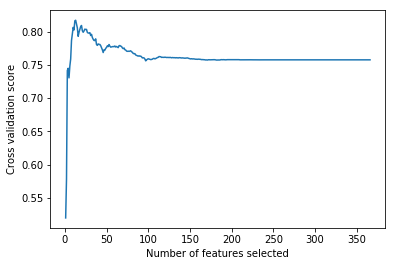

In [62]:
print("Optimal number of features : %d" % selectorREFCV.n_features_)
print(selectorREFCV.support_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selectorREFCV.grid_scores_) + 1), selectorREFCV.grid_scores_)
plt.show()

In [63]:
RFECVrank = selectorREFCV.ranking_
features60 = pd.DataFrame({'Feature':features_df.columns.values, 'Rank':RFECVrank}).sort_values('Rank')
selected_features = features60[0:60]
selected_features.head()


,Feature,Rank
368,AATSC0s,1
320,ATSC6are,1
1335,CIC5,1
603,GATS3se,1
1783,JGI5,1


As suggested by RFECV result, we can select the 60 features with highest scores.